# Deep Learning Assignment 3 - Part 1

Student 1: Raneem Ibraheem + 212920896

Student 2: Aseel Nahhas + 212245096

# Import required libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import re

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import the dataset and showcase a few samples

In [3]:
songs_df = pd.read_csv('Songs.csv')
songs_df.head()

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...
3,Taylor Swift,the 1,"I'm doing good, I'm on some new shit\nBeen say..."
4,Taylor Swift,Look What You Made Me Do,I don't like your little games\nDon't like you...


# Printing the artists names with the number of associated songs

In [4]:
artist_song_count = songs_df['Artist'].value_counts()
print(artist_song_count)

Artist
Taylor Swift          50
David Bowie           50
Billy Joel            50
Eric Clapton          50
Billie Eilish         50
Leonard Cohen         50
Bruce Springsteen     40
The Beatles           35
Ray LaMontagne        30
Elton John            30
Queen                 30
Frank Sinatra         30
John Denver           30
Bryan Adams           30
​twenty one pilots    30
Nat King Cole         30
Lana Del Rey          30
Vance Joy             30
George Michael        30
Bob Dylan             20
Ed Sheeran            20
Name: count, dtype: int64


# Printing the dataset size and the amount of songs

In [5]:
dataset_size = songs_df.shape
total_songs = len(songs_df)
print(f"Dataset size (rows, columns): {dataset_size}")
print(f"Total number of songs: {total_songs}")

Dataset size (rows, columns): (745, 3)
Total number of songs: 745


# Printing the average number of chars and average number of words per song

In [6]:
average_characters = songs_df['Lyrics'].apply(len).mean()
average_words = songs_df['Lyrics'].apply(lambda x: len(x.split())).mean()

print(f"Average number of characters per song: {average_characters}")
print(f"Average number of words per song: {average_words}")

Average number of characters per song: 1403.3476510067114
Average number of words per song: 276.26040268456376


# Visualize the words using word cloud and print the most used words

Top 3 most used words: [('the', 7458), ('I', 6719), ('you', 5475)]


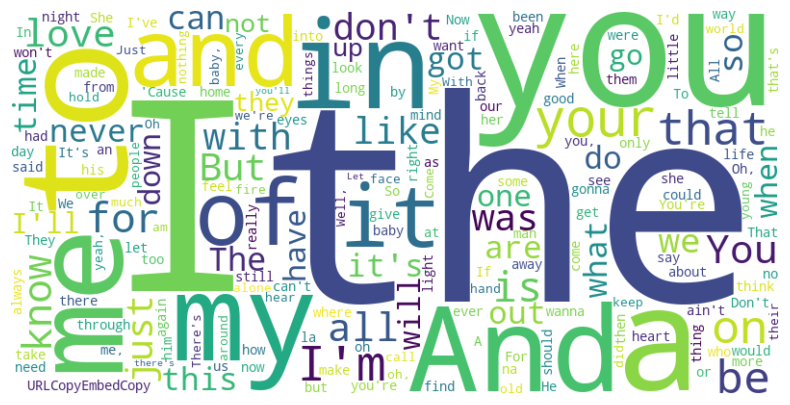

In [7]:
all_lyrics = ' '.join(songs_df['Lyrics'])
word_counts = Counter(all_lyrics.split())
top_3_words = word_counts.most_common(3)
print("Top 3 most used words:", top_3_words)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Preprocessing the data and encoding it

In [8]:
corpus = songs_df['Lyrics'].tolist()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

cleaned_corpus = [clean_text(lyrics) for lyrics in corpus]

all_words = ' '.join(cleaned_corpus).split()
vocab = sorted(list(set(all_words)))
word2idx = {word: i+1 for i, word in enumerate(vocab)}
idx2word = {i: word for word, i in word2idx.items()}
vocab_size = len(word2idx) + 1

tokenized_corpus = []
for lyrics in cleaned_corpus:
    tokens = lyrics.split()
    tokenized = [word2idx[word] for word in tokens if word in word2idx]
    tokenized_corpus.append(torch.tensor(tokenized, dtype=torch.long))

input_sequences = []
target_sequences = []
for tokens in tokenized_corpus:
    if len(tokens) < 2:
        continue
    input_sequences.append(tokens[:-1])
    target_sequences.append(tokens[1:])

input_padded = torch.nn.utils.rnn.pad_sequence(input_sequences, batch_first=True, padding_value=0)
target_padded = torch.nn.utils.rnn.pad_sequence(target_sequences, batch_first=True, padding_value=0)

In [9]:
class LyricsLSTM_LM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers):
        super(LyricsLSTM_LM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)
        output = self.fc(lstm_out)
        return output, hidden

embedding_dim = 128
hidden_dim = 256
n_layers = 2

model = LyricsLSTM_LM(vocab_size, embedding_dim, hidden_dim, n_layers).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
batch_size = 16
dataset = TensorDataset(input_padded, target_padded)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_epochs = 100
training_loss = []

print(f"Using device: {device}")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        outputs = outputs.reshape(-1, vocab_size)
        targets = targets.reshape(-1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)
    training_loss.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

Using device: cuda
Epoch 1/100, Loss: 7.1606
Epoch 2/100, Loss: 6.5107
Epoch 3/100, Loss: 6.4851
Epoch 4/100, Loss: 6.4874
Epoch 5/100, Loss: 6.4769
Epoch 6/100, Loss: 6.4537
Epoch 7/100, Loss: 6.4001
Epoch 8/100, Loss: 6.2901
Epoch 9/100, Loss: 6.1641
Epoch 10/100, Loss: 6.0529
Epoch 11/100, Loss: 5.9578
Epoch 12/100, Loss: 5.8881
Epoch 13/100, Loss: 5.8045
Epoch 14/100, Loss: 5.7408
Epoch 15/100, Loss: 5.6707
Epoch 16/100, Loss: 5.6093
Epoch 17/100, Loss: 5.5513
Epoch 18/100, Loss: 5.4907
Epoch 19/100, Loss: 5.4412
Epoch 20/100, Loss: 5.3833
Epoch 21/100, Loss: 5.3309
Epoch 22/100, Loss: 5.2873
Epoch 23/100, Loss: 5.2384
Epoch 24/100, Loss: 5.1931
Epoch 25/100, Loss: 5.1452
Epoch 26/100, Loss: 5.1025
Epoch 27/100, Loss: 5.0607
Epoch 28/100, Loss: 5.0168
Epoch 29/100, Loss: 4.9804
Epoch 30/100, Loss: 4.9392
Epoch 31/100, Loss: 4.8940
Epoch 32/100, Loss: 4.8505
Epoch 33/100, Loss: 4.8161
Epoch 34/100, Loss: 4.7802
Epoch 35/100, Loss: 4.7435
Epoch 36/100, Loss: 4.6978
Epoch 37/100, Loss

# Plot the loss

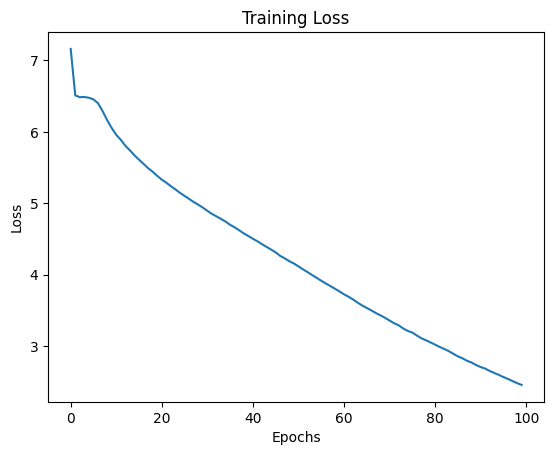

In [11]:
plt.plot(range(num_epochs), training_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Lyrics generation function

In [16]:
def LyricsGenerator(starting_string, char_count, strategy='top_k', k=5, p=0.8):
    model.eval()
    generated = starting_string.strip()
    
    tokens = clean_text(starting_string).split()
    input_indices = [word2idx.get(word, 0) for word in tokens if word in word2idx]
    
    if len(input_indices) == 0:
        random_token = np.random.choice(list(word2idx.values()))
        input_indices = [random_token]
        generated = idx2word.get(random_token, '')
    
    input_tensor = torch.tensor(input_indices, dtype=torch.long).unsqueeze(0).to(device)
    
    hidden = None
    
    while len(generated) < char_count:
        with torch.no_grad():
            outputs, hidden = model(input_tensor, hidden)
            last_logits = outputs[0, -1, :]
            probs = torch.softmax(last_logits, dim=0)
            
            if strategy == 'greedy':
                _, next_token = torch.max(probs, dim=0)
                next_token = next_token.item()
            elif strategy == 'top_k':
                topk_probs, topk_indices = torch.topk(probs, k)
                topk_probs = topk_probs / torch.sum(topk_probs)
                next_token = int(np.random.choice(topk_indices.cpu().numpy(), p=topk_probs.cpu().numpy()))
            elif strategy == 'nucleus':
                sorted_probs, sorted_indices = torch.sort(probs, descending=True)
                cumulative_probs = torch.cumsum(sorted_probs, dim=0)
                cutoff = cumulative_probs > p
                if torch.any(cutoff):
                    cutoff_index = torch.nonzero(cutoff, as_tuple=False)[0].item()
                    filtered_probs = sorted_probs[:cutoff_index+1]
                    filtered_indices = sorted_indices[:cutoff_index+1]
                else:
                    filtered_probs = sorted_probs
                    filtered_indices = sorted_indices
                filtered_probs = filtered_probs / torch.sum(filtered_probs)
                next_token = int(np.random.choice(filtered_indices.cpu().numpy(), p=filtered_probs.cpu().numpy()))
            else:
                raise ValueError("Unknown strategy provided.")
            
            next_word = idx2word.get(next_token, '')
            generated += ' ' + next_word
            
            next_tensor = torch.tensor([[next_token]], dtype=torch.long).to(device)
            input_tensor = torch.cat([input_tensor, next_tensor], dim=1)
            
    return generated


# Song generation

In [18]:
target_char_count = int(average_characters)

song1_start = "it’s not a silly little moment"
print("=== Song 1 Generation ===")
print("-> Top-k Sampling:")
print(LyricsGenerator(song1_start, target_char_count, strategy='top_k', k=5))
print("\n-> Nucleus Sampling (Top-p):")
print(LyricsGenerator(song1_start, target_char_count, strategy='nucleus', p=0.8))
print("\n-----------------------------\n")

song2_start = "There used to be a greying tower"
print("=== Song 2 Generation ===")
print("-> Top-k Sampling:")
print(LyricsGenerator(song2_start, target_char_count, strategy='top_k', k=5))
print("\n-> Nucleus Sampling (Top-p):")
print(LyricsGenerator(song2_start, target_char_count, strategy='nucleus', p=0.8))
print("\n-----------------------------\n")

song3_start = ""
print("=== Song 3 Generation ===")
print("-> Top-k Sampling:")
print(LyricsGenerator(song3_start, target_char_count, strategy='top_k', k=5))
print("\n-> Nucleus Sampling (Top-p):")
print(LyricsGenerator(song3_start, target_char_count, strategy='nucleus', p=0.8))
print("\n-----------------------------\n")


=== Song 1 Generation ===
-> Top-k Sampling:
it’s not a silly little moment is a surprise we used to be the same is young he was just the first day he came to get me a plum we didnt start the fire and he took her out in a yellow submarine yellow submarine yellow submarine yellow submarine all the first times he said to get her down tonight he shall be levon and he learned to be a man and he shall be levon a little gauche i had to live and he never had a marvelous my way and i took him to greasy lake it was dead by the light of a roundabout his father was born to the one to hold with his hand said one i thought to know the joy that he was working on a stool in the band but she fell in a onehorse open sleigh he likes a marvelous time and he wants to change my way and i rosin up the mountain on the light of a cadillac a scream hang the fire and he shall be levon and he was just a twister had to be a woman in a visionary band and he was scarred by the wind was was the way of it i see her t